In [2]:
  # Install and import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
# Generator: takes random noise (latent vector) and generates an image
class Generator(nn.Module):
    def __init__(self, noise_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, img_dim),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        return self.model(z)

# Discriminator: takes an image and predicts real (1) or fake (0)
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.2),  ## 0.2 negative_slope of Leaky Relu
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output is a probability
        )

    def forward(self, x):
        return self.model(x)


In [4]:
# Load MNIST dataset and normalize images to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataloader = DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=40, shuffle=True
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 14.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.43MB/s]


In [5]:
img_dim = 28 * 28   # Flattened MNIST image size
noise_dim = 100     # Dimension of noise vector

G = Generator(noise_dim, img_dim).to(device)
D = Discriminator(img_dim).to(device)

loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss
opt_G = optim.Adam(G.parameters(), lr=0.00002)
opt_D = optim.Adam(D.parameters(), lr=0.00002)


In [6]:
epochs = 50

for epoch in range(epochs):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.view(-1, img_dim).to(device)
        batch_size = real_imgs.size(0)

        # ----------------------
        # Train Discriminator
        # ----------------------
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = G(noise)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())

        loss_D = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ----------------------
        # Train Generator
        # ----------------------
        fake_imgs = G(noise)
        D_fake = D(fake_imgs)

        # We want the generator to trick the discriminator → target label is 1
        loss_G = loss_fn(D_fake, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")


Epoch [1/50]  Loss D: 1.0802, Loss G: 0.5471
Epoch [2/50]  Loss D: 1.1081, Loss G: 0.6224
Epoch [3/50]  Loss D: 0.8500, Loss G: 0.8508
Epoch [4/50]  Loss D: 0.6649, Loss G: 1.1503
Epoch [5/50]  Loss D: 0.6583, Loss G: 1.1884
Epoch [6/50]  Loss D: 0.6245, Loss G: 1.2365
Epoch [7/50]  Loss D: 0.5910, Loss G: 1.2953
Epoch [8/50]  Loss D: 0.6250, Loss G: 1.3092
Epoch [9/50]  Loss D: 0.5910, Loss G: 1.3428
Epoch [10/50]  Loss D: 0.5944, Loss G: 1.3631
Epoch [11/50]  Loss D: 0.5415, Loss G: 1.4222
Epoch [12/50]  Loss D: 0.5016, Loss G: 1.4549
Epoch [13/50]  Loss D: 0.5921, Loss G: 1.4660
Epoch [14/50]  Loss D: 0.4982, Loss G: 1.5180
Epoch [15/50]  Loss D: 0.6427, Loss G: 1.5458
Epoch [16/50]  Loss D: 0.5991, Loss G: 1.4355
Epoch [17/50]  Loss D: 0.7014, Loss G: 1.4550
Epoch [18/50]  Loss D: 0.6979, Loss G: 1.4514
Epoch [19/50]  Loss D: 0.6022, Loss G: 1.4137
Epoch [20/50]  Loss D: 0.5831, Loss G: 1.3509
Epoch [21/50]  Loss D: 0.6964, Loss G: 1.3113
Epoch [22/50]  Loss D: 0.6866, Loss G: 1.42

## Inference

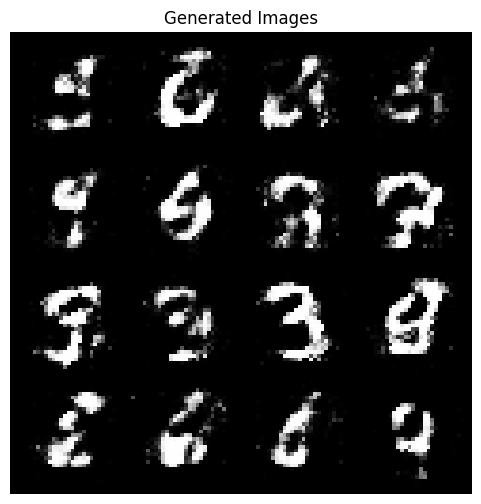

In [7]:
## initial epochs 5
import torchvision
def show_generated_images(generator, n=16):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(n, noise_dim).to(device)
        fake_imgs = generator(noise).reshape(-1, 1, 28, 28)
        fake_imgs = fake_imgs * 0.5 + 0.5  # Rescale to [0,1]

        grid = torchvision.utils.make_grid(fake_imgs, nrow=4)
        plt.figure(figsize=(6,6))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.title("Generated Images")
        plt.show()

show_generated_images(G)


## Tune  hyperparameters to improve results

## Use another Pytorch dataset with this model to generate

## Plot Generator and Discriminator Losses